# Hackathon: Box Office Prediction

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling imports
from sklearn.linear_model import LinearRegression # import the LinearRegression class
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score

from sklearn.ensemble import RandomForestRegressor

import warnings

In [141]:
tmdb_orig = pd.read_csv('./data/train.csv')

# drop the following columns due to: large number of missing values (belongs_to_collection), 3000 unique values (homepage, imdb_id, poster_path)
# keyword is stronger (original_title, overview, tagline, title), one dominant trait (status)

drop_cols = ['id','belongs_to_collection', 'homepage','imdb_id','original_title',
            'overview','poster_path','status','tagline']

tmdb_orig.drop(columns=drop_cols, inplace=True)

tmdb_orig.dropna(inplace=True)
tmdb_orig.reset_index(inplace=True, drop=True)

tmdb_orig.shape

(2609, 14)

In [6]:
num_features = ['title','budget','original_language','popularity','release_date','runtime','revenue']
tmdb = tmdb_orig[num_features]
tmdb.head()

,title,budget,original_language,popularity,release_date,runtime,revenue
0,Hot Tub Time Machine 2,14000000,en,6.575393,2/20/15,93.0,12314651
1,The Princess Diaries 2: Royal Engagement,40000000,en,8.248895,8/6/04,113.0,95149435
2,Whiplash,3300000,en,64.299990,10/10/14,105.0,13092000
3,Muppet Treasure Island,0,en,6.902423,2/16/96,100.0,34327391
4,A Mighty Wind,6000000,en,4.672036,4/16/03,91.0,18750246


In [233]:
tmdb['original_language'].value_counts(normalize=True).head()

en    0.879708
fr    0.024596
es    0.014988
ja    0.010761
hi    0.010377
Name: original_language, dtype: float64

In [235]:
tmdb[tmdb['budget']==380_000_000]

,title,budget,original_language,popularity,release_date,runtime,revenue,month,year,log_revenue
1856,Pirates of the Caribbean: On Stranger Tides,380000000,en,27.88772,2011-05-14,136.0,1045713802,5,2011,20.767966


In [236]:
tmdb[tmdb['revenue']==tmdb['revenue'].max()]

,title,budget,original_language,popularity,release_date,runtime,revenue,month,year,log_revenue
979,The Avengers,220000000,en,89.887648,2012-04-25,143.0,1519557910,4,2012,21.141685


## Check for null values and remove

In [7]:
tmdb.isnull().sum()

title                0
budget               0
original_language    0
popularity           0
release_date         0
runtime              0
revenue              0
dtype: int64

In [8]:
# convert date to extract month and year
tmdb['release_date'] = pd.to_datetime(tmdb['release_date'])
tmdb['month'] = pd.DatetimeIndex(tmdb['release_date']).month
tmdb['year'] = pd.DatetimeIndex(tmdb['release_date']).year

<ipython-input-8-2dfc0c5a033e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmdb['release_date'] = pd.to_datetime(tmdb['release_date'])
<ipython-input-8-2dfc0c5a033e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmdb['month'] = pd.DatetimeIndex(tmdb['release_date']).month
<ipython-input-8-2dfc0c5a033e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [9]:
# statistics
tmdb.describe()

,budget,popularity,runtime,revenue,month,year
count,2.609000e+03,2609.000000,2609.000000,2.609000e+03,2609.000000,2609.000000
mean,2.483175e+07,9.072135,108.769644,7.367050e+07,6.817555,2005.016098
std,3.822689e+07,11.344896,21.497669,1.422334e+08,3.406122,16.512722
min,0.000000e+00,0.000578,0.000000,1.000000e+00,1.000000,1971.000000
25%,1.510000e+05,5.184013,95.000000,3.956913e+06,4.000000,1995.000000
50%,1.028452e+07,7.903956,105.000000,2.110775e+07,7.000000,2005.000000
75%,3.200000e+07,11.239012,119.000000,8.093623e+07,10.000000,2012.000000
max,3.800000e+08,287.253654,338.000000,1.519558e+09,12.000000,2070.000000


Statistics observations:
* Budget: there are some movies with zero budgets. Check that out
* Popularity: mean is 9, so there are some outliers (max = 287.25)
* Runtime: max runtime is long (but not unreasonable)
* Revenue: min of 1 is odd
* Month: ranges from 1 to 12 as expected
* Year: Max is 2070 which is in the future. Odd

In [10]:
# datetime error: So it seems that anything with the %y year below 69 will be attributed a century of 2000, and 69 upwards get 1900
# convert these

# function to convert year
def convert_year(year):
    if year > 2021:
        return year-100
    else:
        return year

tmdb['year'] = tmdb['year'].apply(convert_year)
tmdb['year'].value_counts().sort_index(ascending=False)

<ipython-input-10-0b3e692af066>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmdb['year'] = tmdb['year'].apply(convert_year)


2021      1
2017     33
2016    114
2015    108
2014    110
       ... 
1928      1
1927      1
1926      1
1925      1
1924      1
Name: year, Length: 90, dtype: int64

### Budget

In [11]:
# # replace the rows with budget of zero, with the mean of the other budgets
# # decided this because even movies with zero budget had a revenue
# # and anyway there were 811 of them, so we didn't want to drop these rows

# mean_budget = tmdb[tmdb['budget']>0]['budget'].mean()

# # Blair Witch project budget was $60,000. so this seems like a reasonable minimum movie budget
# # replace lower values with the mean of the others

# def replace_budget(value):
#     if value < 60_000:
#         return mean_budget
#     else:
#         return value
    
# tmdb['budget'] = tmdb['budget'].apply(replace_budget)
# # tmdb.loc[tmdb['budget']==0]['budget'] = tmdb[tmdb['budget']>0]['budget'].mean()

In [12]:
tmdb['budget'].value_counts().sort_index(ascending=False)

380000000      1
300000000      1
280000000      1
270000000      1
260000000      2
            ... 
5              1
4              1
2              1
1              3
0            615
Name: budget, Length: 368, dtype: int64

In [13]:
# check stats again
tmdb.describe()

,budget,popularity,runtime,revenue,month,year
count,2.609000e+03,2609.000000,2609.000000,2.609000e+03,2609.000000,2609.000000
mean,2.483175e+07,9.072135,108.769644,7.367050e+07,6.817555,1999.266769
std,3.822689e+07,11.344896,21.497669,1.422334e+08,3.406122,15.598568
min,0.000000e+00,0.000578,0.000000,1.000000e+00,1.000000,1924.000000
25%,1.510000e+05,5.184013,95.000000,3.956913e+06,4.000000,1992.000000
50%,1.028452e+07,7.903956,105.000000,2.110775e+07,7.000000,2003.000000
75%,3.200000e+07,11.239012,119.000000,8.093623e+07,10.000000,2011.000000
max,3.800000e+08,287.253654,338.000000,1.519558e+09,12.000000,2021.000000


### Popularity

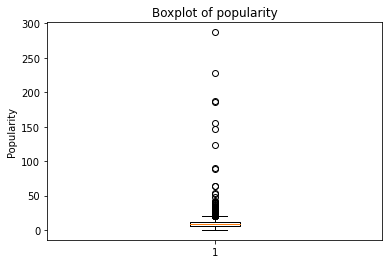

In [14]:
plt.boxplot(tmdb['popularity'])
plt.title('Boxplot of popularity')
plt.ylabel('Popularity')
plt.show()

Some movies are just wildly popular.

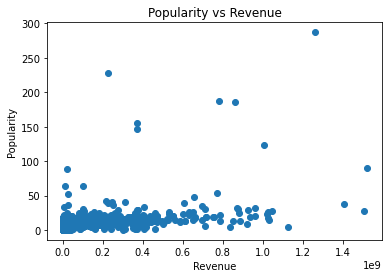

In [15]:
# zoom
plt.scatter(tmdb['revenue'],tmdb['popularity'])
plt.title('Popularity vs Revenue')
plt.xlabel('Revenue')
plt.ylabel('Popularity')
# plt.ylim([-10, 100])
plt.show()

Maybe remove items above popularity=100 and revenue=1.2B?

In [16]:
tmdb = tmdb[tmdb['popularity']<100]
tmdb.describe()

,budget,popularity,runtime,revenue,month,year
count,2.602000e+03,2602.000000,2602.000000,2.602000e+03,2602.000000,2602.000000
mean,2.457188e+07,8.592080,108.707148,7.199409e+07,6.820907,1999.224058
std,3.780608e+07,6.000705,21.478375,1.374616e+08,3.407510,15.596932
min,0.000000e+00,0.000578,0.000000,1.000000e+00,1.000000,1924.000000
25%,1.380038e+05,5.162012,95.000000,3.917041e+06,4.000000,1992.000000
50%,1.000000e+07,7.885318,105.000000,2.102752e+07,7.000000,2003.000000
75%,3.100000e+07,11.214562,119.000000,7.969166e+07,10.000000,2011.000000
max,3.800000e+08,89.887648,338.000000,1.519558e+09,12.000000,2021.000000


In [17]:
tmdb.shape

(2602, 9)

### Revenue

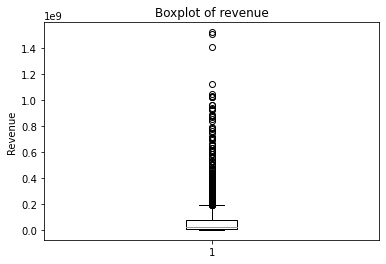

In [18]:
# This is our target variable
plt.boxplot(tmdb['revenue'])
plt.title('Boxplot of revenue')
plt.ylabel('Revenue')
plt.show()

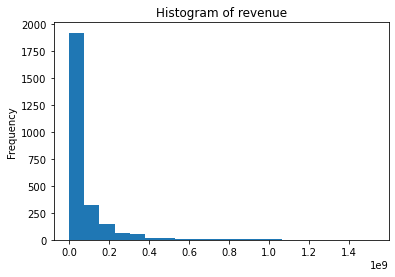

In [19]:
# histogram of revenue
plt.hist(tmdb['revenue'], bins=20)
plt.title('Histogram of revenue')
plt.ylabel('Frequency')
plt.show()

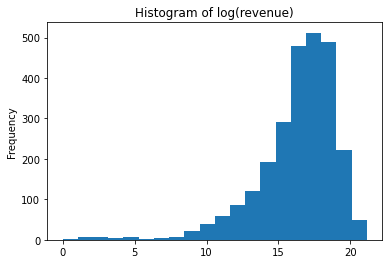

In [20]:
# target distribution is skewed. Try taking a log
plt.hist(np.log(tmdb['revenue']), bins=20)
plt.title('Histogram of log(revenue)')
plt.ylabel('Frequency')
plt.show()

In [21]:
tmdb['log_revenue'] = np.log(tmdb['revenue'])

### Correlation

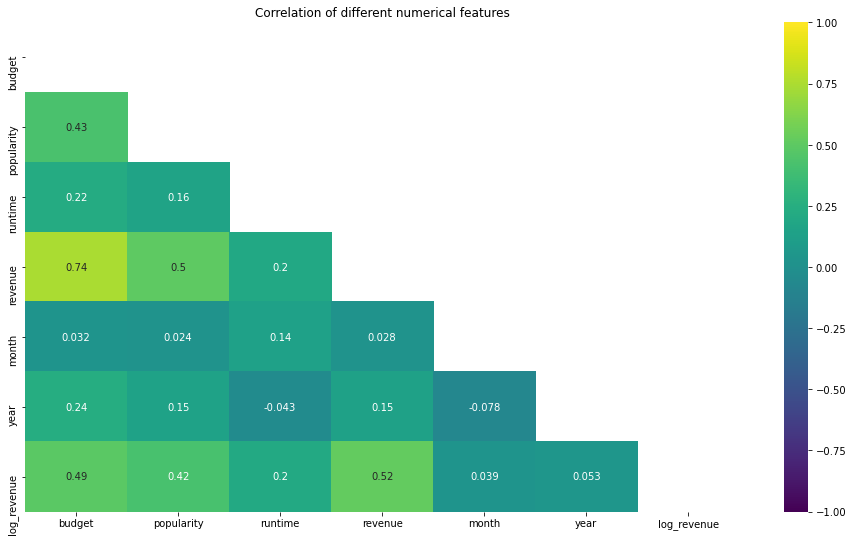

In [22]:
plt.figure(figsize=(16,9))
corr=tmdb.corr()

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
g=sns.heatmap(corr,annot=True,cmap='viridis',vmin=-1,vmax=1,mask=mask)
plt.title('Correlation of different numerical features')
plt.show()

Budget correlates strongly with revenue, followed by popularity. Surprisingly, revenue does not correlate with month (summer blockbusters??).

# Modeling

In [23]:
model_features = ['budget','original_language','popularity','runtime','month','year']
# model_features = ['budget','popularity','runtime','year']
X = tmdb[model_features]
X = pd.get_dummies(data=X,columns=['original_language'], drop_first=True)
y = tmdb['revenue'] # target

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Linear Regression

In [25]:
# instantiate
lr = LinearRegression()
cross_val_score(estimator=lr, X=X_train, y=y_train).mean(), cross_val_score(estimator=lr, X=X_train, y=y_train).std()

(0.5782376669133036, 0.07336414826817789)

In [26]:
lr.fit(X_train, y_train)

LinearRegression()

In [27]:
lr.score(X_train, y_train)

0.6124900833507625

In [28]:
lr.score(X_test, y_test)

0.5016884752695583

This model is overfit. And anyway not that good. It has an R^2 of 0.53.

In [29]:
y_preds = lr.predict(X_test)

In [30]:
resids = y_test - y_preds

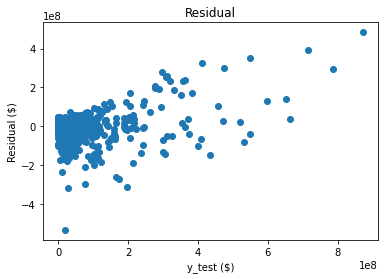

In [31]:
plt.scatter(y_test,resids)
plt.title('Residual')
plt.xlabel('y_test ($)')
plt.ylabel('Residual ($)')
plt.show()

The residual distribution has a pattern to it, which means our linear regression model is not great.

In [32]:
# root mean squared error (RMSE)
RMSE = metrics.mean_squared_error(y_true=y_test, y_pred=y_preds, squared=False) 
print(RMSE)

78811596.3398929


In [33]:
# baseline model (average of revenue)
avg_rev = np.full((len(y_test),1), tmdb['revenue'].mean())
RMSE_bsl = metrics.mean_squared_error(y_true=y_test, y_pred=avg_rev, squared=False) 
print(RMSE_bsl)

111935927.95849217


Our Linear Regression model is not great. It is overfit, with an R^2 of 0.5. The RMSE is \\$78.8M. This RMSE is better than the baseline model using average revenue (\\$112M).

In [34]:
# coeff
pd.DataFrame(lr.coef_, index=X.columns, columns=['Coefficients']).head()
# lr.coef_

,Coefficients
budget,2.464165e+00
popularity,6.311533e+06
runtime,1.955840e+04
month,-5.857123e+05
year,-4.638959e+05


For each \\$1 increase in budget, the revenue would increase by \\$2.46, all else remaining equal.

## Random Forest

In [35]:
rfr = RandomForestRegressor()

# define dictionary of hyperparameters
rfr_params = {
    'n_estimators': [10, 100, 200, 500],
    'max_depth': [5, 10, 20],
    'random_state': [42]
}

# instantiate GridSearchCV object
rfr_gs = GridSearchCV(estimator = rfr,
                     param_grid = rfr_params,
                     cv=5,
                     verbose=1,
                     n_jobs=4)

# Fit the GridSearchCV object to the data.
rfr_gs.fit(X_train, y_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.4s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   31.1s finished


In [36]:
# RandomForestRegressor best score
rfr_gs.best_score_

0.6169816757567347

In [37]:
# best parameters
rfr_gs.best_params_

{'max_depth': 10, 'n_estimators': 100, 'random_state': 42}

In [38]:
# Evaluate the best model on the test data.

print(f"RandomForestRegressor train score: {rfr_gs.score(X_train, y_train)}")
print(f"RandomForestRegressor test score: {rfr_gs.score(X_test, y_test)}")

RandomForestRegressor train score: 0.9094386563295812
RandomForestRegressor test score: 0.5583589512644367


Model is grossly overfit.

In [39]:
print(f"RMSE RandomForest (train): {metrics.mean_squared_error(y_true = y_train, y_pred=rfr_gs.predict(X_train), squared=False)}")
print(f"RMSE RandomForest (test): {metrics.mean_squared_error(y_true = y_test, y_pred=rfr_gs.predict(X_test), squared=False)}")

RMSE RandomForest (train): 43612556.143770866
RMSE RandomForest (test): 74194954.83734567


RandomForest does a slightly better job than LinearRegression, with a testing RMSE of \\$74.2M.

In [40]:
coeffs = pd.DataFrame(data=[X.columns, rfr_gs.best_estimator_.feature_importances_]).T
coeffs.columns = ['index','coeffs']
coeffs.sort_values(by='coeffs', ascending=False).head()

,index,coeffs
0,budget,0.636037
1,popularity,0.180605
2,runtime,0.0821243
3,month,0.0511749
4,year,0.0462876


It looks like budget is most important, followed by popularity.

## 1.0 Convert Strings in Columns to Dictionary/List

In [142]:
import warnings
import ast

In [143]:
# Convert Strings in Columns to Dictionary and Lists
tmdb_orig['Keywords'] = tmdb_orig['Keywords'].apply(lambda x: ast.literal_eval(x))
tmdb_orig['genres'] = tmdb_orig['genres'].apply(lambda x: ast.literal_eval(x))
tmdb_orig['production_companies'] = tmdb_orig['production_companies'].apply(lambda x: ast.literal_eval(x))
tmdb_orig['production_countries'] = tmdb_orig['production_countries'].apply(lambda x: ast.literal_eval(x))
tmdb_orig['cast'] = tmdb_orig['cast'].apply(lambda x: ast.literal_eval(x))
tmdb_orig['crew'] = tmdb_orig['crew'].apply(lambda x: ast.literal_eval(x))

# https://stackoverflow.com/questions/39169718/convert-string-to-dict-then-access-keyvalues-how-to-access-data-in-a-class

In [144]:
# train_df_nonan = tmdb_orig[tmdb_orig['popularity']<100]
train_df_nonan = tmdb_orig

In [194]:
tmdb_orig.shape

(2609, 21)

### 1.1 Extraction of Data In Keyword Column

In [146]:
train_df_nonan['Keywords'][2] # Inspect the structure of the Dictionary/List

[{'id': 1416, 'name': 'jazz'},
 {'id': 1523, 'name': 'obsession'},
 {'id': 1640, 'name': 'conservatory'},
 {'id': 2176, 'name': 'music teacher'},
 {'id': 14512, 'name': 'new york city'},
 {'id': 14819, 'name': 'violence'},
 {'id': 33896, 'name': 'montage'},
 {'id': 156823, 'name': 'drummer'},
 {'id': 170418, 'name': 'public humiliation'},
 {'id': 176095, 'name': 'jazz band'},
 {'id': 206298, 'name': 'young adult'},
 {'id': 207739, 'name': 'music school'}]

In [147]:
keyword_empty = [] # Final List

for i in range(0,len(train_df_nonan)): # Loop Through all the Rows
    
    keywordempty = [] # Temp list to collate data we loop thru
    
    try:
        for j in range(0,len(train_df_nonan['Keywords'][i])): # Loop thru all elements in Lists
            keywordempty.append(str(train_df_nonan['Keywords'][i][j]['name']).replace(" ", "_")) # Append key element to list and replace ' ' with '_'   
    except:
        continue
    
    keyword_empty.append(keywordempty) # Cast sub-lists to final list

In [148]:
keyword_empty[2] # Inspect to ensure change above occured as expected

['jazz',
 'obsession',
 'conservatory',
 'music_teacher',
 'new_york_city',
 'violence',
 'montage',
 'drummer',
 'public_humiliation',
 'jazz_band',
 'young_adult',
 'music_school']

In [149]:
warnings.filterwarnings('ignore') # Supress Warnings
train_df_nonan['keywords_loop'] = keyword_empty

In [150]:
warnings.filterwarnings('ignore') # Supress Warnings
train_df_nonan['keywords_loop'] = train_df_nonan['keywords_loop'].apply(lambda x: " ".join(x))

In [151]:
train_df_nonan['keywords_loop'].head() # Final Inspection

0      time_travel sequel hot_tub duringcreditsstinger
1             coronation duty marriage falling_in_love
2    jazz obsession conservatory music_teacher new_...
3              island pirate_gang puppet treasure_hunt
4                             mockumentary folk_singer
Name: keywords_loop, dtype: object

### 1.2 Extraction of Data from Genres Column

In [152]:
train_df_nonan['genres'][3] # Inspect and Understand the structure of the Dictionary/List

[{'id': 28, 'name': 'Action'},
 {'id': 35, 'name': 'Comedy'},
 {'id': 10402, 'name': 'Music'},
 {'id': 10751, 'name': 'Family'},
 {'id': 12, 'name': 'Adventure'}]

In [153]:
genre_empty = [] # Final List

for i in range(0,len(train_df_nonan)): # Loop Through all the Rows
    
    genreempty = [] # Temp list to collate data we loop thru
    
    try:
        for j in range(0,len(train_df_nonan['genres'][i])): # Loop thru all elements in Lists
            genreempty.append(str(train_df_nonan['genres'][i][j]['name']).replace(" ", "_"))    
    except:
        continue
    
    genre_empty.append(genreempty) # Cast sub-lists to final list

In [154]:
genre_empty[3] # Verify that change above executed

['Action', 'Comedy', 'Music', 'Family', 'Adventure']

In [155]:
warnings.filterwarnings('ignore') # Supress Warnings
train_df_nonan['genre_loop'] = genre_empty

In [156]:
warnings.filterwarnings('ignore') # Supress Warnings
train_df_nonan['genre_loop'] = train_df_nonan['genre_loop'].apply(lambda x: " ".join(x))

In [157]:
train_df_nonan['genre_loop'].head() # Verify that change above executed

0                                  Comedy
1             Comedy Drama Family Romance
2                                   Drama
3    Action Comedy Music Family Adventure
4                            Comedy Music
Name: genre_loop, dtype: object

### 1.3 Extraction of Data from Production Company Column

In [158]:
train_df_nonan['production_companies'][0]

[{'name': 'Paramount Pictures', 'id': 4},
 {'name': 'United Artists', 'id': 60},
 {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]

In [159]:
prod_comp_empty = [] # Final List

for i in range(0,len(train_df_nonan)): # Loop Through all the Rows
    
    prodcompempty = []  # Temp list to collate data we loop thru
    
    try:
        for j in range(0,len(train_df_nonan['production_companies'][i])): # Loop thru all elements in Lists
            prodcompempty.append(str(train_df_nonan['production_companies'][i][j]['name']).replace(" ", "_"))    
    except:
        continue
    
    prod_comp_empty.append(prodcompempty) # Cast sub-lists to final list

In [160]:
prod_comp_empty[0] # Verify that change above executed

['Paramount_Pictures', 'United_Artists', 'Metro-Goldwyn-Mayer_(MGM)']

In [161]:
warnings.filterwarnings('ignore') # Supress Warnings
train_df_nonan['comp_loop'] = prod_comp_empty

In [162]:
warnings.filterwarnings('ignore') # Supress Warnings
train_df_nonan['comp_loop'] = train_df_nonan['comp_loop'].apply(lambda x: " ".join(x))

In [163]:
train_df_nonan['comp_loop'].head() # Verify that change above executed

0    Paramount_Pictures United_Artists Metro-Goldwy...
1                                 Walt_Disney_Pictures
2    Bold_Films Blumhouse_Productions Right_of_Way_...
3    Walt_Disney_Pictures Jim_Henson_Productions Ji...
4                            Castle_Rock_Entertainment
Name: comp_loop, dtype: object

### 1.4 Extraction of Data from Production Country Column

In [164]:
train_df_nonan['production_countries'][8] # Inspect Dictionary Structure

[{'iso_3166_1': 'US', 'name': 'United States of America'}]

In [165]:
prod_co_empty = [] # Final List

for i in range(0,len(train_df_nonan)): # Loop Through all the Rows
    
    prodcoempty = []  # Temp list to collate data we loop thru
    
    try:
        for j in range(0,len(train_df_nonan['production_countries'][i])):
            prodcoempty.append(str(train_df_nonan['production_countries'][i][j]['name']).replace(" ", "_"))    
    except:
        continue
    
    prod_co_empty.append(prodcoempty)
        
# https://stackoverflow.com/questions/39169718/convert-string-to-dict-then-access-keyvalues-how-to-access-data-in-a-class

In [166]:
prod_co_empty[8] # Verify that change above executed

['United_States_of_America']

In [167]:
warnings.filterwarnings('ignore') # Supress Warnings
train_df_nonan['country_loop'] = prod_co_empty

In [168]:
warnings.filterwarnings('ignore') # Supress Warnings
train_df_nonan['country_loop'] = train_df_nonan['country_loop'].apply(lambda x: " ".join(x))

In [169]:
train_df_nonan['country_loop'].head() # Verify that change above executed

0    United_States_of_America
1    United_States_of_America
2    United_States_of_America
3    United_States_of_America
4    United_States_of_America
Name: country_loop, dtype: object

### 1.5 Extraction of Data from Cast Column

In [170]:
train_df_nonan['cast'][0]  # Inspect Dictionary Structure

[{'cast_id': 4,
  'character': 'Lou',
  'credit_id': '52fe4ee7c3a36847f82afae7',
  'gender': 2,
  'id': 52997,
  'name': 'Rob Corddry',
  'order': 0,
  'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'},
 {'cast_id': 5,
  'character': 'Nick',
  'credit_id': '52fe4ee7c3a36847f82afaeb',
  'gender': 2,
  'id': 64342,
  'name': 'Craig Robinson',
  'order': 1,
  'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'},
 {'cast_id': 6,
  'character': 'Jacob',
  'credit_id': '52fe4ee7c3a36847f82afaef',
  'gender': 2,
  'id': 54729,
  'name': 'Clark Duke',
  'order': 2,
  'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'},
 {'cast_id': 7,
  'character': 'Adam Jr.',
  'credit_id': '52fe4ee7c3a36847f82afaf3',
  'gender': 2,
  'id': 36801,
  'name': 'Adam Scott',
  'order': 3,
  'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'},
 {'cast_id': 8,
  'character': 'Hot Tub Repairman',
  'credit_id': '52fe4ee7c3a36847f82afaf7',
  'gender': 2,
  'id': 54812,
  'name': 'Chevy Chase',
  'order': 4,
  'prof

In [171]:
cast_empty = [] 

for i in range(0,len(train_df_nonan)):
    
    castempty = []
    
    try:
        for j in range(0,len(train_df_nonan['cast'][i])):
            if j <= 3:
                castempty.append(str(train_df_nonan['cast'][i][j]['name']).replace(" ", "_"))
            else:
                continue
    except:
        continue
    
    cast_empty.append(castempty) # Cast sub-lists to final list

In [172]:
cast_empty[8] # Verify that change above executed

['John_Travolta', 'Uma_Thurman', 'Vince_Vaughn', 'Cedric_the_Entertainer']

In [173]:
warnings.filterwarnings('ignore') # Supress Warnings
train_df_nonan['cast'] = cast_empty

In [174]:
warnings.filterwarnings('ignore') # Supress Warnings
train_df_nonan['cast'] = train_df_nonan['cast'].apply(lambda x: " ".join(x))

In [175]:
train_df_nonan['cast'].head() # Verify that change above executed

0     Rob_Corddry Craig_Robinson Clark_Duke Adam_Scott
1    Anne_Hathaway Julie_Andrews H√©ctor_Elizondo J...
2    Miles_Teller J.K._Simmons Melissa_Benoist Aust...
3    Tim_Curry Kevin_Bishop Jennifer_Saunders Billy...
4    Bob_Balaban Christopher_Guest John_Michael_Hig...
Name: cast, dtype: object

### 1.6 Extraction of Data from Crew Column

In [176]:
train_df_nonan['crew'][1]

[{'credit_id': '52fe43fe9251416c7502563d',
  'department': 'Directing',
  'gender': 2,
  'id': 1201,
  'job': 'Director',
  'name': 'Garry Marshall',
  'profile_path': '/kx77E8p5rnEmKxIhFT0qWCEMEik.jpg'},
 {'credit_id': '52fe43fe9251416c75025667',
  'department': 'Camera',
  'gender': 2,
  'id': 1214,
  'job': 'Director of Photography',
  'name': 'Charles Minsky',
  'profile_path': None},
 {'credit_id': '52fe43fe9251416c75025661',
  'department': 'Sound',
  'gender': 2,
  'id': 4500,
  'job': 'Original Music Composer',
  'name': 'John Debney',
  'profile_path': '/hTrlvZlDXQk49nfc2BM9sjKfJv.jpg'},
 {'credit_id': '52fe43fe9251416c7502564f',
  'department': 'Production',
  'gender': 1,
  'id': 8851,
  'job': 'Producer',
  'name': 'Whitney Houston',
  'profile_path': '/69ouDnXnmklYPr4sMJXWKYz81AL.jpg'},
 {'credit_id': '52fe43fe9251416c7502566d',
  'department': 'Editing',
  'gender': 0,
  'id': 12970,
  'job': 'Editor',
  'name': 'Bruce Green',
  'profile_path': '/yplxWPVgwK1b33AjvbhM9mWX2

#### 1.6.1 Extraction of Data from Crew Column Just the Director

In [177]:
crew_dir_empty = []

for i in range(0,len(train_df_nonan)):
    
    crewempty = []
    
    try:
        for j in range(0,len(train_df_nonan['crew'][i])):
            if train_df_nonan['crew'][i][j]['job'] == 'Director':
                crewempty.append(str(train_df_nonan['crew'][i][j]['name']).replace(" ", "_"))
            else:
                continue
    except:
        continue
    
    crew_dir_empty.append(crewempty)

In [178]:
warnings.filterwarnings('ignore') # Supress Warnings
train_df_nonan['crew_dir'] =  crew_dir_empty

In [179]:
warnings.filterwarnings('ignore') # Supress Warnings
train_df_nonan['crew_dir'] = train_df_nonan['crew_dir'].apply(lambda x: " ".join(x))

In [180]:
train_df_nonan['crew_dir'].head() # Verify that change above executed

0           Steve_Pink
1       Garry_Marshall
2      Damien_Chazelle
3         Brian_Henson
4    Christopher_Guest
Name: crew_dir, dtype: object

#### 1.6.2 Extraction of Data from Crew Column, Just the Director Of Photography

In [181]:
crew_dirp_empty = []

for i in range(0,len(train_df_nonan)):
    
    crewempty = []
    
    try:
        for j in range(0,len(train_df_nonan['crew'][i])):
            if train_df_nonan['crew'][i][j]['job'] == 'Director of Photography':
                crewempty.append(str(train_df_nonan['crew'][i][j]['name']).replace(" ", "_"))
            else:
                continue
    except:
        continue
    
    crew_dirp_empty.append(crewempty)

In [182]:
crew_dirp_empty[1] # Verify that change above executed

['Charles_Minsky']

In [183]:
warnings.filterwarnings('ignore') # Supress Warnings
train_df_nonan['crew_dir_photo']=crew_dirp_empty

In [184]:
warnings.filterwarnings('ignore') # Supress Warnings
train_df_nonan['crew_dir_photo'] = train_df_nonan['crew_dir_photo'].apply(lambda x: " ".join(x))

In [185]:
train_df_nonan.head() # Verify that change above executed

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,title,Keywords,cast,crew,revenue,keywords_loop,genre_loop,comp_loop,country_loop,crew_dir,crew_dir_photo
0,14000000,"[{'id': 35, 'name': 'Comedy'}]",en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...",Rob_Corddry Craig_Robinson Clark_Duke Adam_Scott,"[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,time_travel sequel hot_tub duringcreditsstinger,Comedy,Paramount_Pictures United_Artists Metro-Goldwy...,United_States_of_America,Steve_Pink,Declan_Quinn
1,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...",Anne_Hathaway Julie_Andrews H√©ctor_Elizondo J...,"[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,coronation duty marriage falling_in_love,Comedy Drama Family Romance,Walt_Disney_Pictures,United_States_of_America,Garry_Marshall,Charles_Minsky
2,3300000,"[{'id': 18, 'name': 'Drama'}]",en,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...",Miles_Teller J.K._Simmons Melissa_Benoist Aust...,"[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,jazz obsession conservatory music_teacher new_...,Drama,Bold_Films Blumhouse_Productions Right_of_Way_...,United_States_of_America,Damien_Chazelle,Sharone_Meir
3,0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",en,6.902423,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/16/96,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Muppet Treasure Island,"[{'id': 2041, 'name': 'island'}, {'id': 4418, ...",Tim_Curry Kevin_Bishop Jennifer_Saunders Billy...,"[{'credit_id': '52fe43c89251416c7501deb3', 'de...",34327391,island pirate_gang puppet treasure_hunt,Action Comedy Music Family Adventure,Walt_Disney_Pictures Jim_Henson_Productions Ji...,United_States_of_America,Brian_Henson,John_Fenner
4,6000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",en,4.672036,"[{'name': 'Castle Rock Entertainment', 'id': 97}]","[{'iso_3166_1': 'US', 'name': 'United States o...",4/16/03,91.0,"[{'iso_639_1': 'en', 'name': 'English'}]",A Mighty Wind,"[{'id': 11800, 'name': 'mockumentary'}, {'id':...",Bob_Balaban Christopher_Guest John_Michael_Hig...,"[{'credit_id': '52fe45609251416c750545b3', 'de...",18750246,mockumentary folk_singer,Comedy Music,Castle_Rock_Entertainment,United_States_of_America,Christopher_Guest,Arlene_Nelson


## 2.0 Concat Final Text Columns

In [186]:
train_df_nonan['text'] = train_df_nonan['country_loop'] + ' ' + train_df_nonan['keywords_loop'] + ' ' + train_df_nonan['genre_loop'] + ' ' +train_df_nonan['comp_loop']  + ' ' + train_df_nonan['crew_dir_photo']  + ' ' + train_df_nonan['crew_dir']  + ' ' + train_df_nonan['cast']

In [187]:
final_df = train_df_nonan['text']

In [188]:
final_df.head()

0    United_States_of_America time_travel sequel ho...
1    United_States_of_America coronation duty marri...
2    United_States_of_America jazz obsession conser...
3    United_States_of_America island pirate_gang pu...
4    United_States_of_America mockumentary folk_sin...
Name: text, dtype: object

## Prep for Modeling with CountVect

In [189]:
from sklearn.feature_extraction.text import CountVectorizer

In [190]:
cv = CountVectorizer(min_df=2)
final_df_cv = cv.fit_transform(final_df)

In [191]:
# Store the transformed data
X1_df = pd.DataFrame(final_df_cv.todense(), columns=cv.get_feature_names())
X1_df.head()

,10th_hole_productions,120db_films,1492_pictures,15th_century,17th_century,18th_century,1920s,1930s,1940s,1950s,...,æt_delhomme,æt_magimel,ñski,òverste_hylde,ópalo_films,ô_bucur,ökerman,österreichischer_rundfunk_,øm,ƒçek
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [192]:
X1_df.shape

(2609, 7059)

In [195]:
tmdb_orig.shape

(2609, 21)

In [196]:
X1_df['popularity'] = tmdb_orig['popularity']

In [200]:
X1_df = X1_df[X1_df['popularity']<100]
X1_df.shape

(2602, 7059)

In [201]:
X1_df.drop(columns='popularity', inplace=True) 

In [202]:
X1_df.shape

(2602, 7058)

In [205]:
df_concat = pd.concat([tmdb,X1_df], axis=1)

In [206]:
df_concat.shape

(2602, 7068)

## Modeling

In [208]:
tmdb.columns

Index(['title', 'budget', 'original_language', 'popularity', 'release_date',
       'runtime', 'revenue', 'month', 'year', 'log_revenue'],
      dtype='object')

In [209]:
# model_features = ['budget','original_language','popularity','runtime','month','year']
# model_features = ['budget','popularity','runtime','year']
X2 = df_concat.drop(columns=['title','release_date','revenue','log_revenue'])
X2 = pd.get_dummies(data=X2,columns=['original_language'], drop_first=True)
y2 = df_concat['revenue'] # target

In [210]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42)

## Linear Regression with CountVectorized columns

In [211]:
# instantiate
lr2 = LinearRegression()
cross_val_score(estimator=lr2, X=X2_train, y=y2_train).mean(), cross_val_score(estimator=lr2, X=X2_train, y=y2_train).std()

(0.5391305312250123, 0.07144758652129048)

In [217]:
lr2.fit(X2_train, y2_train)

LinearRegression()

In [218]:
lr2.score(X2_train, y2_train)

0.9999999999999645

In [219]:
lr2.score(X2_test, y2_test)

0.36301465185036197

This model is way overfit. And performs worse than the basic LinearRegression model. This one has an R^2 of 0.36.

In [220]:
y2_preds = lr2.predict(X2_test)

In [221]:
resids2 = y2_test - y2_preds

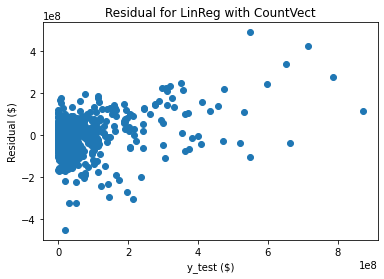

In [226]:
plt.scatter(y2_test,resids2)
plt.title('Residual for LinReg with CountVect')
plt.xlabel('y_test ($)')
plt.ylabel('Residual ($)')
plt.show()

The residual distribution has a pattern to it, which means our linear regression model is not great.

In [227]:
# root mean squared error (RMSE)
RMSE2 = metrics.mean_squared_error(y_true=y2_test, y_pred=y2_preds, squared=False) 
print(RMSE2)

89105473.01635109


In [224]:
# baseline model (average of revenue)
# avg_rev = np.full((len(y_test),1), tmdb['revenue'].mean())
# RMSE_bsl = metrics.mean_squared_error(y_true=y_test, y_pred=avg_rev, squared=False) 
print(RMSE_bsl)

111935927.95849217


Our Linear Regression model (that has now taken into account additional features such as Production Country, Cast, and Crew) performs worse than the basic LinearRegression model that just took numerical features (and language) into account. It is severely overfit. The RMSE is \\$89.1M. Though this RMSE is still better than the baseline model using average revenue (\\$112M).

In [228]:
# coeff
pd.DataFrame(lr2.coef_, index=X2.columns, columns=['Coefficients']).head()
# lr.coef_

,Coefficients
budget,2.095839e+00
popularity,4.531137e+06
runtime,1.771687e+05
month,-5.861070e+05
year,-1.354282e+06


For each \\$1 increase in budget, the revenue would increase by \\$2.10, all else remaining equal.

## Random Forest with CountVectorized Columns

In [230]:
## this model ran for 15mins without completing

# rfr2 = RandomForestRegressor()

# # define dictionary of hyperparameters
# rfr2_params = {
#     'n_estimators': [10, 100, 200, 500],
#     'max_depth': [5, 10, 20],
#     'random_state': [42]
# }

# # instantiate GridSearchCV object
# rfr2_gs = GridSearchCV(estimator = rfr2,
#                      param_grid = rfr2_params,
#                      cv=5,
#                      verbose=1,
#                      n_jobs=4)

# # Fit the GridSearchCV object to the data.
# rfr2_gs.fit(X2_train, y2_train);

It looks like budget is most important, followed by popularity.